In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

In [2]:
colnames = ['station', 'ts', 'entries']

daily = pd.read_csv('data/daily_all.csv', names=colnames)
daily['ts'] = pd.to_datetime(daily['ts'])
daily['date'] = daily['ts'].dt.date

hourly = pd.read_csv('data/hourly_all.csv', names=colnames)
hourly['ts'] = pd.to_datetime(hourly['ts'])
hourly['date'] = hourly['ts'].dt.date
hourly['hour'] = hourly['ts'].dt.hour

geo = pd.read_csv('station_geo_lookup.csv')
daily = pd.merge(daily, geo)
hourly = pd.merge(hourly, geo)

In [3]:
first_date = datetime.datetime.strptime('2020-02-08', '%Y-%m-%d').date()
daily = daily[daily.date >= first_date]
hourly = hourly[hourly.date >= first_date]

# Daily totals

In [4]:
events = {
    '2020-03-11': 'Europe travel ban',
    '2020-03-18': 'NY shelter in place announced',
    '2020-03-13': '100th COVID-19 case in NYC',
    '2020-03-01': 'First COVID-19 case in NYC',
    '2020-03-22': '10,000th COVID-19 case in NYC'
}

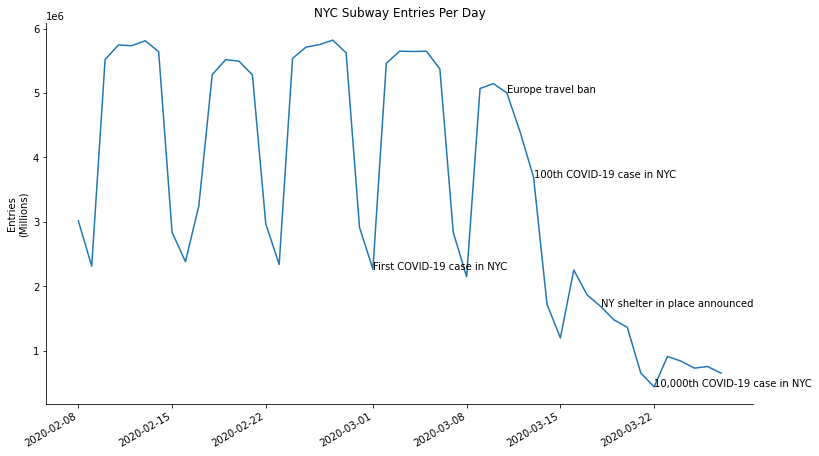

In [10]:
day_totals = daily.groupby('date').sum().reset_index()

g = sns.relplot(x='date', y='entries', kind='line', data=day_totals,
                height=7, aspect=1.5)
g.fig.autofmt_xdate()
plt.title('NYC Subway Entries Per Day')
plt.ylabel('Entries\n(Millions)')
plt.xlabel('')

for datestr, text in events.items():
    date = datetime.datetime.strptime(datestr, '%Y-%m-%d').date()
    val = day_totals[day_totals['date'] == date]['entries']
    g.ax.annotate(text, (date, val))
    
plt.savefig('figures/daily_totals.png', bbox_inches='tight')

In [11]:
start_total = day_totals.sort_values(by='date')[0:7]['entries'].sum()
end_total = day_totals.sort_values(by='date', ascending=False)[0:7]['entries'].sum()
print('First week total: {}'.format(start_total))
print('Last week total: {}'.format(end_total))
print('% change: {}'.format(end_total/start_total - 1))

First week total: 33785986.251869865
Last week total: 4987666.0361882495
% change: -0.852374709472564


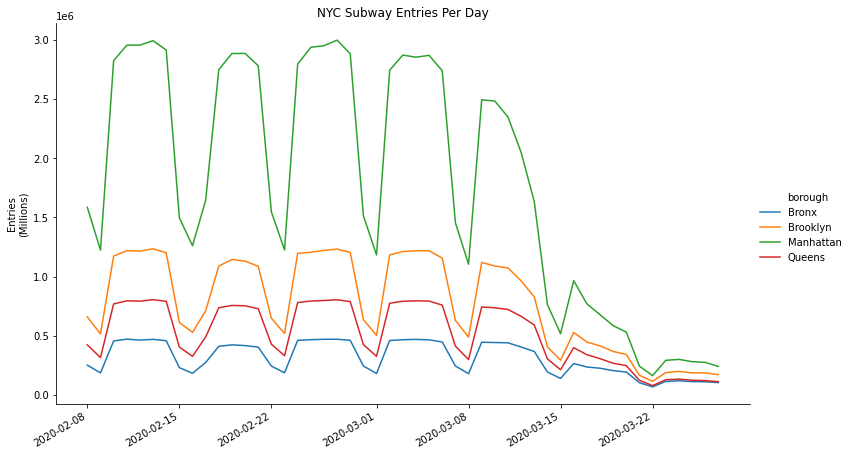

In [12]:
day_totals_b = daily.groupby(['borough', 'date']).sum().reset_index()
day_totals_b = day_totals_b[day_totals_b.borough != 'Staten Island']

g = sns.relplot(x='date', y='entries', kind='line', hue='borough', data=day_totals_b,
               height=7, aspect=1.5)
g.fig.autofmt_xdate()
plt.title('NYC Subway Entries Per Day')
plt.ylabel('Entries\n(Millions)')
plt.xlabel('')

plt.savefig('figures/boroughs.png', bbox_inches='tight')

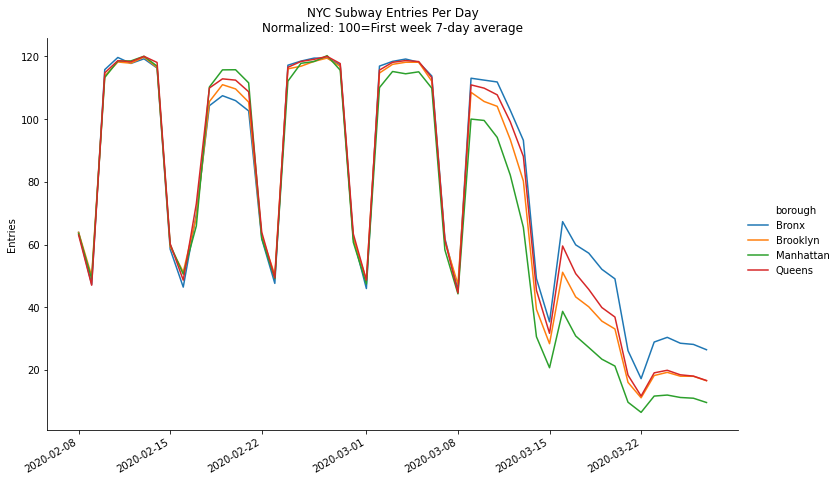

In [13]:
def normalize_first_week(df):
    first7 = df.sort_values(by='date')[0:7]
    first7_avg = first7['entries'].sum() / 7
    df['entries'] = 100 * df['entries'] / first7_avg
    return df

day_totals_b_norm = day_totals_b.groupby('borough', group_keys=False).apply(normalize_first_week)
g = sns.relplot(x='date', y='entries', kind='line', hue='borough', data=day_totals_b_norm,
               height=7, aspect=1.5)
g.fig.autofmt_xdate()
plt.xlabel('')
plt.ylabel('Entries')
plt.title('NYC Subway Entries Per Day\nNormalized: 100=First week 7-day average')

plt.savefig('figures/boroughs_normalized.png', bbox_inches='tight')

# Hour of day heatmap

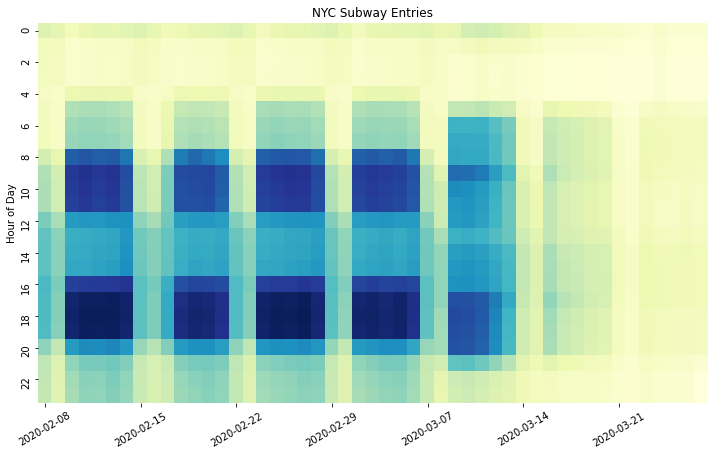

In [14]:
hmap_data = hourly.groupby(['hour', 'date']).sum().reset_index()
hmap_data = hmap_data.pivot('hour', 'date', 'entries')

#ax = plt.axes()
fig, ax = plt.subplots(figsize = (12,7))
hmap = sns.heatmap(hmap_data, ax=ax, cmap='YlGnBu', cbar=False, xticklabels=7, yticklabels=2)
ax.set_title('NYC Subway Entries')
ax.set_xlabel('')
plt.xticks(rotation=30)
ax.set_ylabel('Hour of Day')
plt.savefig('figures/hourly_heatmap.png', bbox_inches='tight')

# Mapping

In [15]:
def make_bbox(df, padding=0.05):
    lat = (df.latitude.min(), df.latitude.max())
    lon = (df.longitude.min(), df.longitude.max())
    def pad_ll(x):
        pad = (x[1] - x[0]) * padding
        return (x[0] - pad, x[1] + pad)
    return {'lat': pad_ll(lat), 'lon': pad_ll(lon)}

bbox_nyc = make_bbox(geo)
bbox_manhattan = make_bbox(geo[geo['borough'] == 'Manhattan'])

In [16]:
print(bbox_nyc)
print(bbox_manhattan)

{'lat': (40.5597771, 40.919474900000004), 'lon': (-74.09080649999999, -73.73943350000002)}
{'lat': (40.678063475, 40.883918025), 'lon': (-74.0192767, -73.90461930000001)}


In [17]:
def first7(vals):
    return vals.sort_index()[0:7].sum() / 7

def last7(vals):
    return vals.sort_index(ascending=False)[0:7].sum() / 7
    
first_last = daily.set_index('date').groupby('station')['entries'].agg([first7, last7])
first_last['change'] = first_last.last7 / first_last.first7 - 1
first_last.reset_index(inplace=True)
first_last = pd.merge(first_last, geo).dropna()

In [18]:
import matplotlib.ticker as mtick

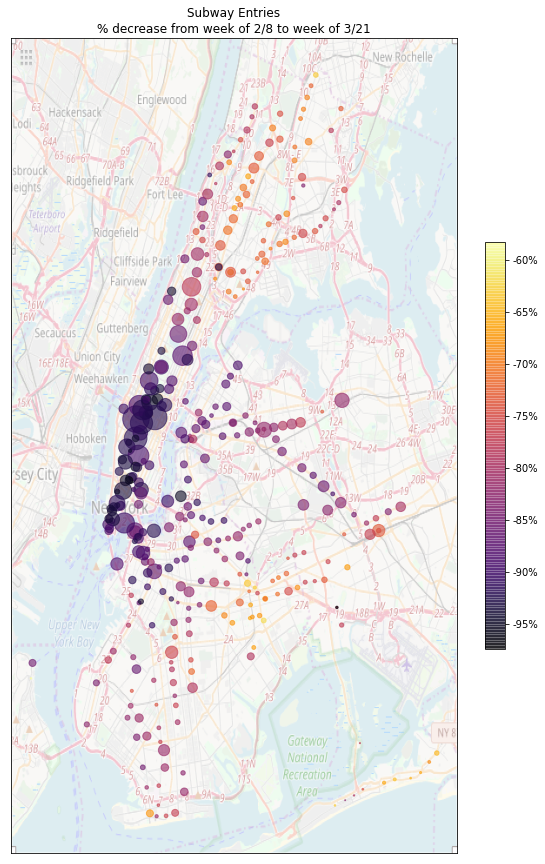

In [19]:
# Map from https://www.openstreetmap.org/export. I just carefully screenshotted the bounding box coordinates.

def make_map(data, bbox, img, fsize, maxsize=700):
    size = maxsize * data.first7 / data.first7.max()
    
    
    fig, ax = plt.subplots(figsize = fsize)

    points = ax.scatter(data.longitude, data.latitude, zorder=1, alpha=0.6, s=size, c=data.change, cmap='inferno')
    
    cbar = fig.colorbar(points, shrink=0.5)
    cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_xlim(*bbox['lon'])
    ax.set_ylim(*bbox['lat'])
    ax.set_yticks([])
    ax.set_xticks([])
    
    ax.set_title('Subway Entries\n% decrease from week of 2/8 to week of 3/21')
    
    mapimg = plt.imread(img)
    ax.imshow(mapimg, zorder=0, extent=[*bbox['lon'], *bbox['lat']], aspect='auto', alpha=0.4)
    
make_map(first_last, bbox_nyc, 'data/nyc_base_map.png', (10, 15))
plt.savefig('figures/station_map.png', bbox_inches='tight')